# Regularization

From the previous lectures, we know that more features do not always lead to better performance. Sometimes, adding more features can lead to overfitting.

In HW4 Q2, we saw that feature selection method can help to prevent overfitting. Choosing a subset of the features will make the model simpler, more interpretable, and less likely to overfit.

In this notebook, we will introduce another way to prevent overfitting: regularization. Regularization is a technique that discourages learning a more complex or flexible model, so as to prevent overfitting.

## Ridge regression

Recall the linear regression model:

$$f(x_i) = \beta_0 + \sum_{j=1}^p x_{ij} \beta_j$$

In the ridge regression, we add a penalty term to the loss function. The optimization problem becomes:

$$
\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p \beta_j^2
$$

where $\alpha$ is the regularization strength.

Here, we are penalizing large value of $\beta$. Intuitively, large coefficients are more sensitive to changes in the input data, which can lead to overfitting.

We can view this as the middle ground of two extremes: 
if $\alpha = 0$, then we are back to the original linear regression model; if $\alpha$ is very large, then we are forcing all the $\beta_1, \beta_2, \ldots, \beta_p$ to be close to 0, and the model becomes a constant model (i.e., $f(x) = \beta_0$).


The previous problem is equivalent to the following constrained optimization problem:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 \\
&\text{subject to} \sum_{j=1}^p \beta_j^2 \leq t
\end{align*}
$$

We are constraining the complexity of the model by limiting the space of $\beta$: instead of finding the optimal $\beta$ in $\mathbb{R}^p$, we are finding the optimal $\beta$ in a $p$-dimensional ball.

There is a one-to-one correspondence between the $\alpha$ in the first formulation and $t$ in the second formulation (see Lagrange multiplier in optimization).


Notice that

- the scaling of the input matters in ridge regression. We need the penalty to be "fair" to all the features. So it's important to standardize the input features before applying ridge regression, which can be achieved by some scaling techniques such as standardization.

- the intercept term $\beta_0$ is not penalized. If $\beta_0$ is penalized, then taking $\lambda$ to be very large will force $\beta_0, \beta_1, \ldots, \beta_p$ to be 0, and the model will be a trivial model (i.e., $f(x) = 0$).



If we assume that the input features and the target variable are centered. (In this case, for ordinary linear regression, the optimal $\beta_0$ is 0)

Then the design matrix $X$ is a $n \times p$ matrix (do not include the column of 1's for the intercept term), and the target variable $y$ is a $n \times 1$ vector.

The ridge regression problem can be written as:

$$
\min_{\beta} \|X \beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$

The optimal solution is:

$$
\hat{\beta}_{\text ridge} = (X^T X + \lambda I)^{-1} X^T y
$$

where $I$ is the identity matrix.
    



We will use the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html) from sklearn to demonstrate the effect of regularization.

Features: 

- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

Target: 

a quantitative measure of disease progression one year after baseline

Let's first visualize the data using the heatmap of the correlation matrix and the pairwise scatter plot.

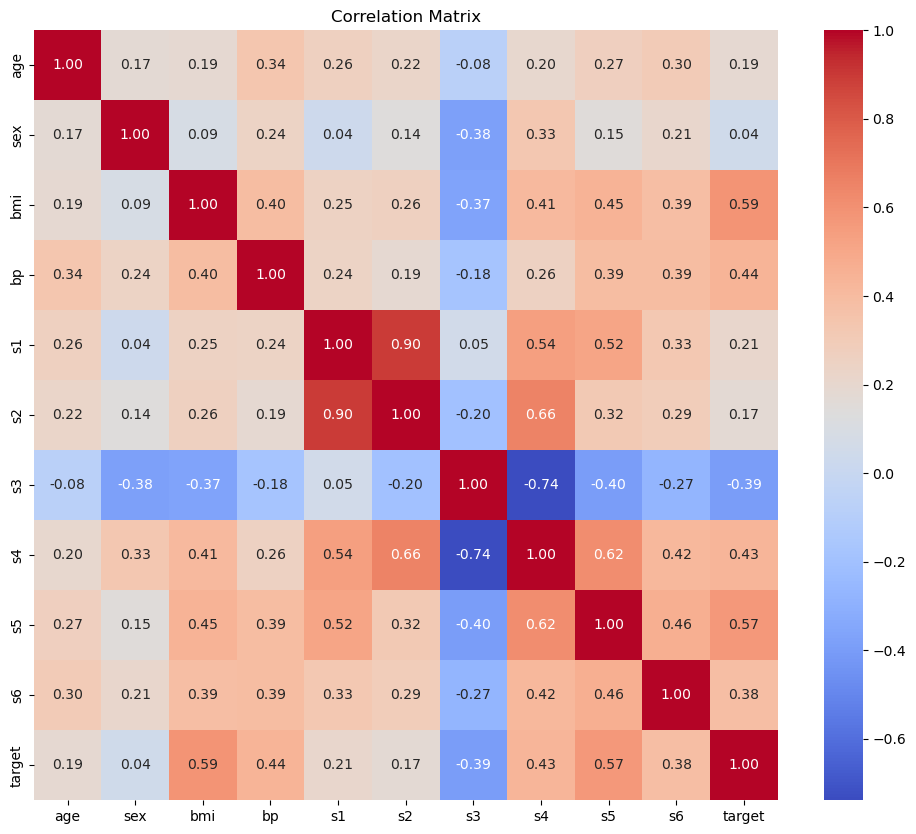

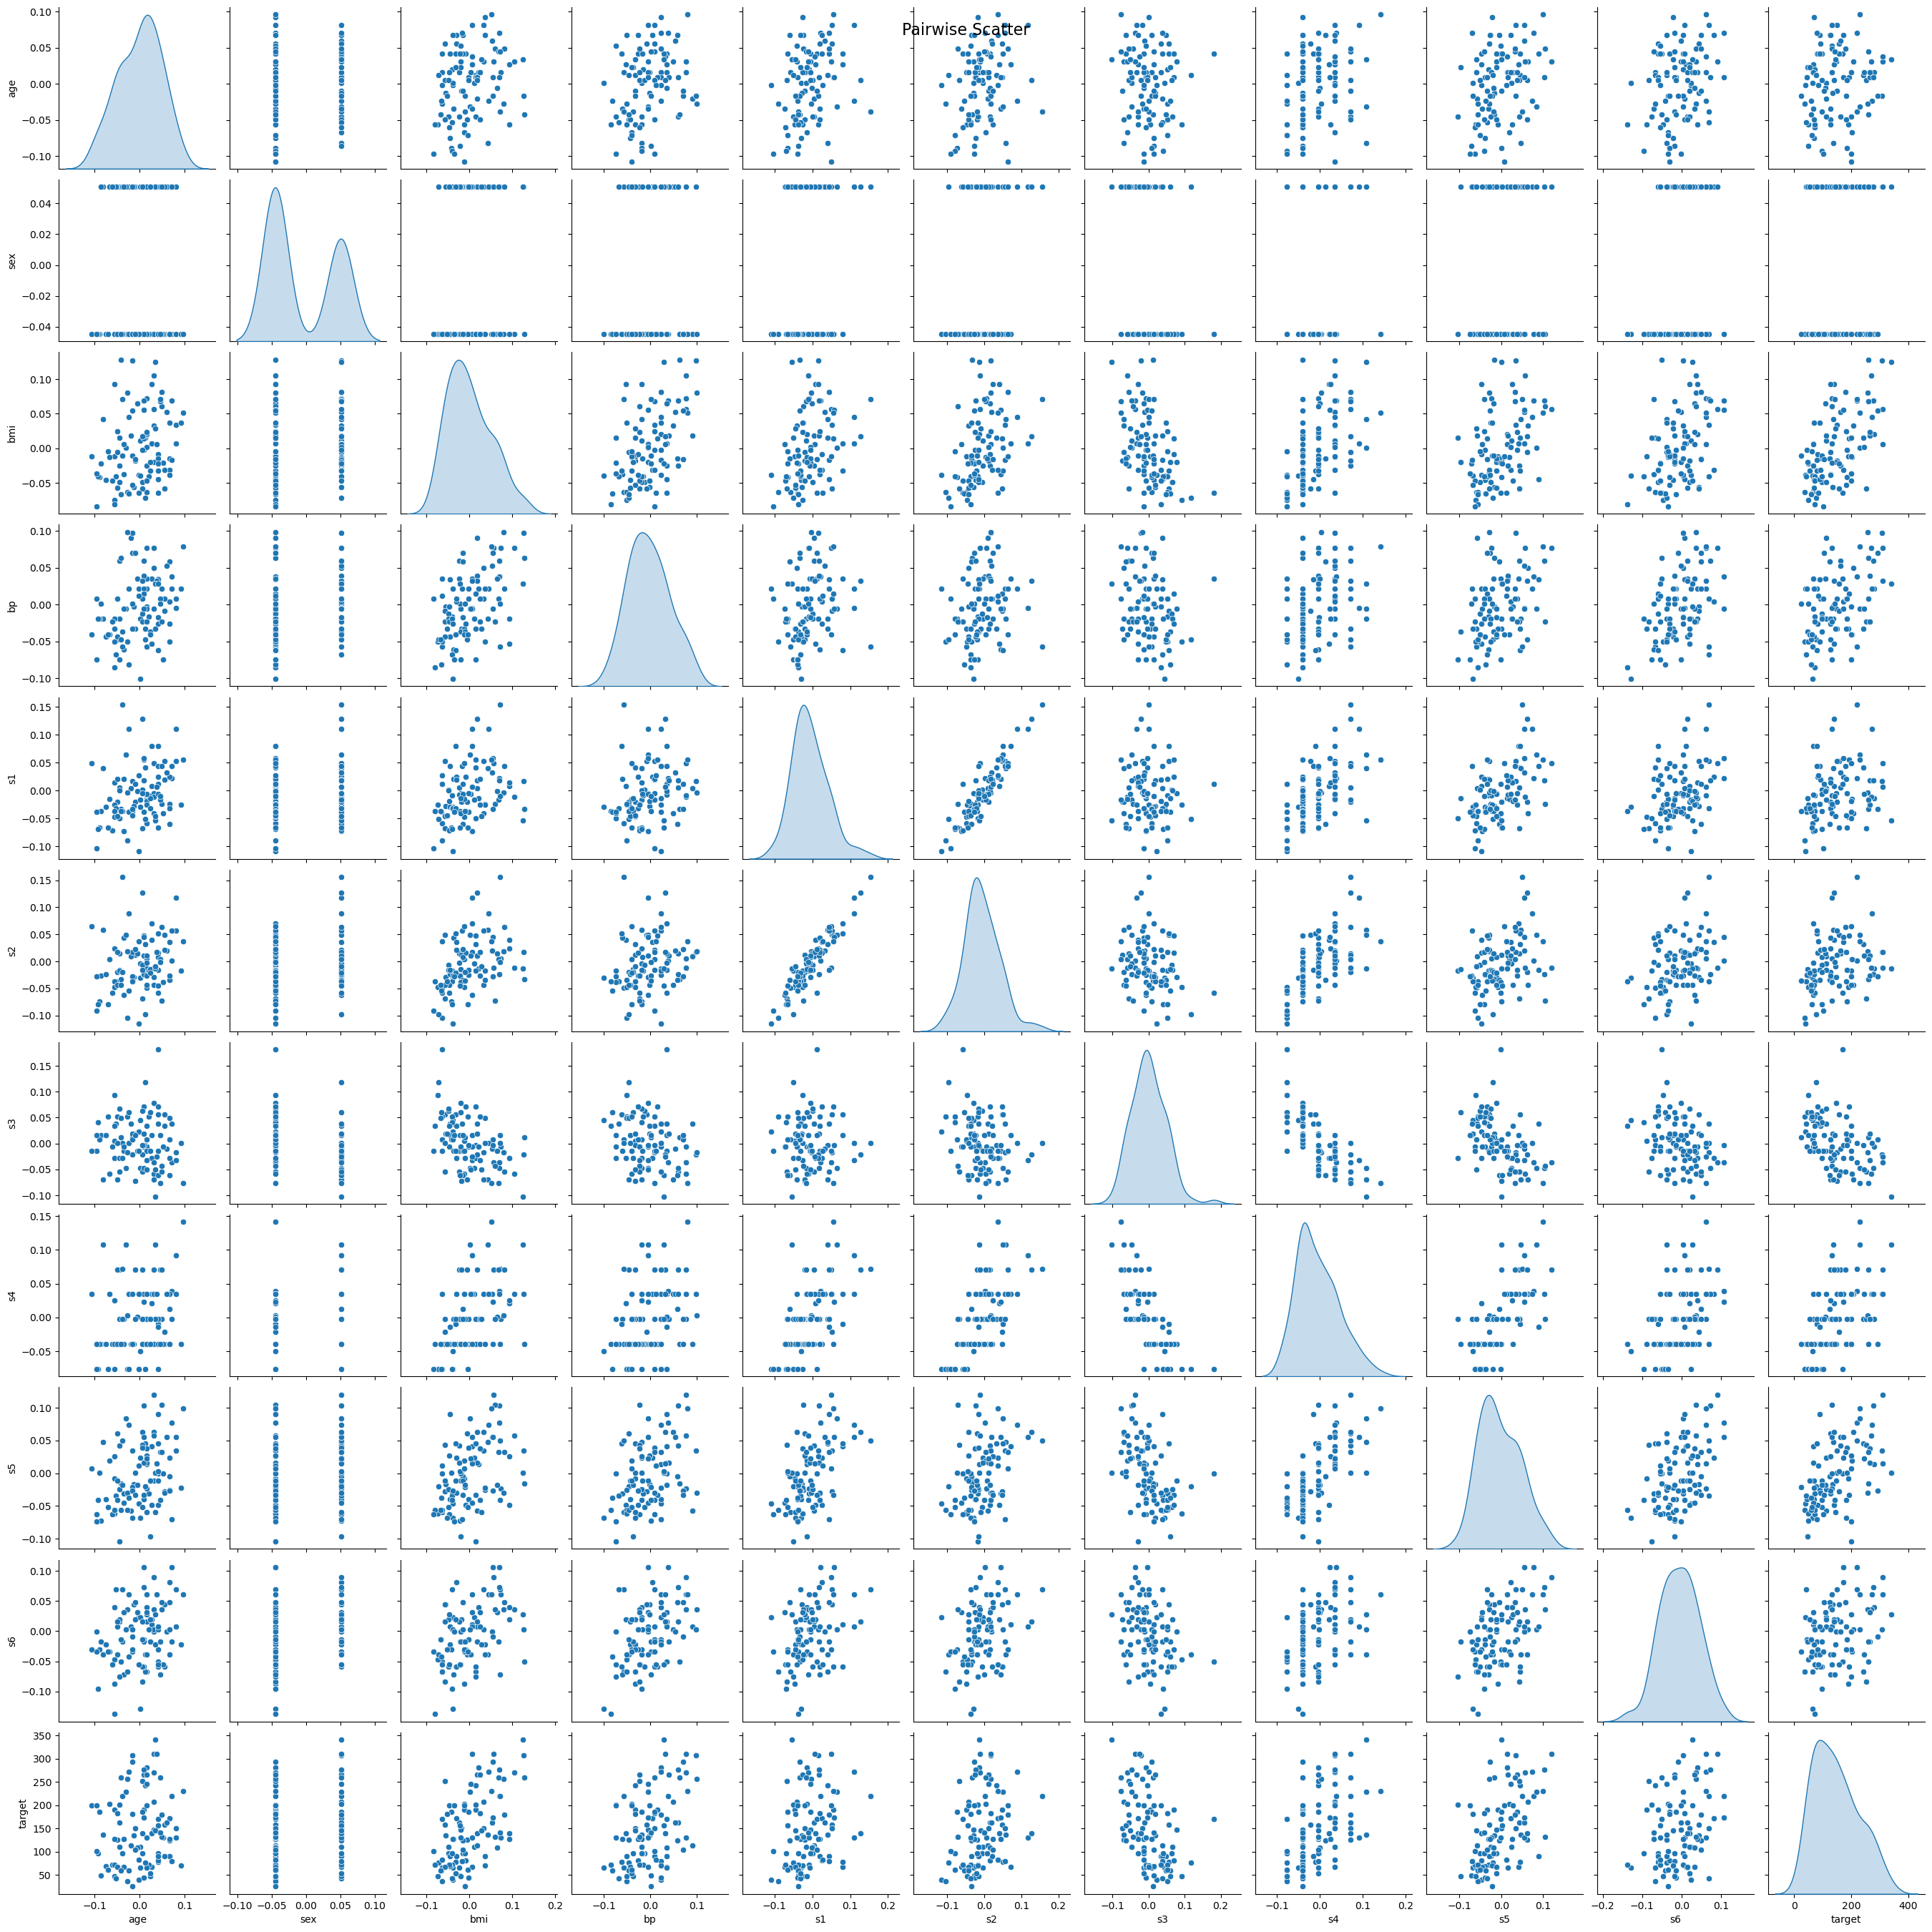

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes

# Load the diabetes dataset as a dataframe
# X is already standardized
data = load_diabetes(as_frame=True)
X = data.data  # Feature data as DataFrame
y = data.target  # Target data as Series

# Combine X and y into a single DataFrame for analysis
df = pd.concat([X, y.rename('target')], axis=1)

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Pairwise scatter plot
# sample 100 data points to make the plot clearer
sns.pairplot(df.sample(100), diag_kind='kde')
plt.suptitle('Pairwise Scatter', size=16)
plt.show()


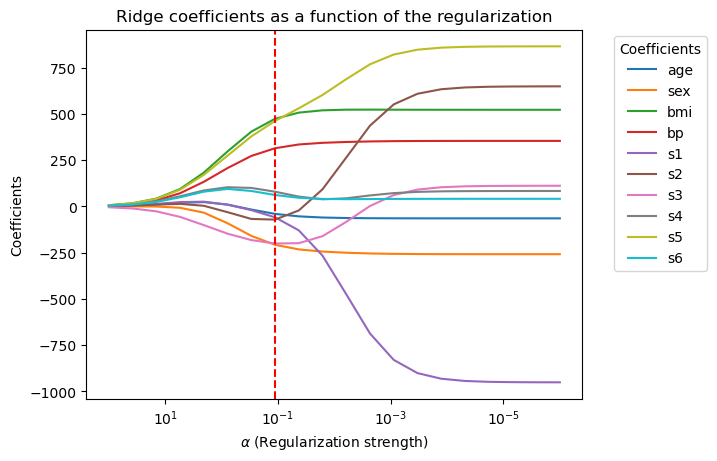

coefficient at min_test_error_alpha: [ -40.29975879 -207.42325577  473.89549682  314.67375928  -58.88723172
  -71.1515363  -200.45697995   79.62340778  462.24473432   61.82651944]


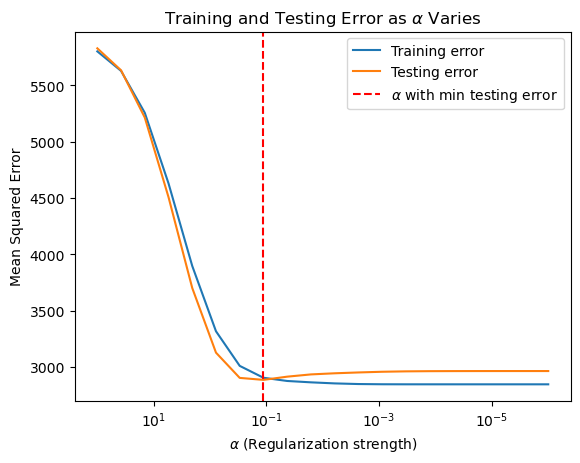

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

# Range of alpha values for regularization, from 10^2 to 10^-6
alphas = np.logspace(2, -6, 20)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_errors = []
test_errors = []

train_r2 = []
test_r2 = []

# Perform Ridge Regression with different values of alpha
for index, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_errors)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_errors)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()

## The Lasso

The lasso is another way to regularize the linear regression model. The optimization problem is:

$$
\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 + \alpha \sum_{j=1}^p |\beta_j|
$$

where $\alpha$ is the regularization strength.

We can also write the problem as a constrained optimization problem:

$$
\begin{align*}
&\min_{\beta}  \sum_{i=1}^N (\beta_0 + \sum_{j=1}^p x_{ij} \beta_j - y_i)^2 \\
&\text{subject to} \sum_{j=1}^p |\beta_j| \leq t
\end{align*}
$$

Compared with ridge regression, the lasso tends to produce sparse solutions: it encourages the coefficients to be exactly 0. 
This is useful in practice because it can help us select a subset of the features.

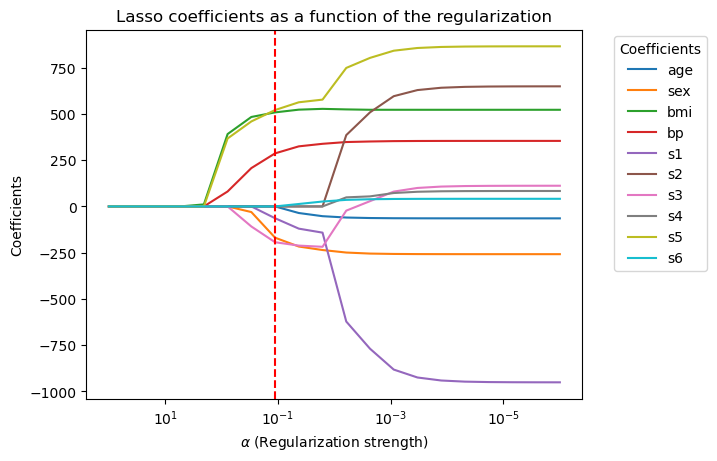

coefficient at min_test_error_alpha: [  -0.         -168.94733268  508.38872566  286.86290699  -63.78716274
   -0.         -193.54527567    0.          521.00758347    0.        ]


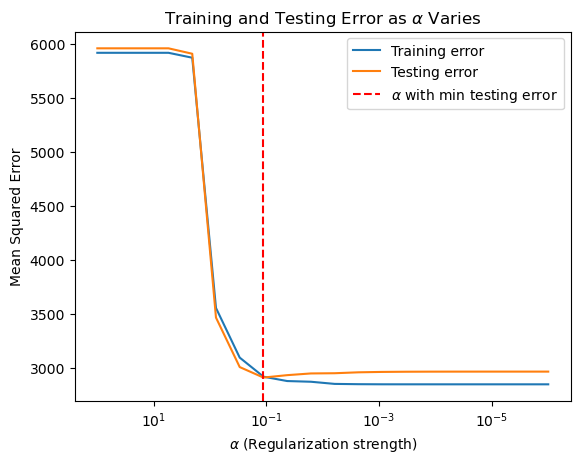

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Load the diabetes dataset as a dataframe
data = load_diabetes(as_frame=True)
X = data.data  # Feature data as DataFrame
y = data.target  # Target data as Series

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

# Range of alpha values for regularization
alphas = np.logspace(2, -6, 20)

# Array to store coefficients
coefficients = np.zeros((len(alphas), X_train.shape[1]))

# Lists to store training and testing errors
train_errors = []
test_errors = []

# Perform Lasso Regression with different values of alpha
for index, alpha in enumerate(alphas):
    ridge = Lasso(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Calculate training and testing errors
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    
    # Store coefficients
    coefficients[index, :] = ridge.coef_

# Find the alpha value that minimizes the testing error
min_test_error_alpha = alphas[np.argmin(test_errors)]

# Plotting coefficients as a function of alpha
plt.figure()
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=X.columns[i])
plt.axvline(min_test_error_alpha, color='red', linestyle='--')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(title="Coefficients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

best_coef = coefficients[np.argmin(test_errors)]
print(f'coefficient at min_test_error_alpha: {best_coef}')

# Plotting training and testing error as a function of alpha
plt.figure()
plt.plot(alphas, train_errors, label='Training error')
plt.plot(alphas, test_errors, label='Testing error')
plt.axvline(min_test_error_alpha, color='red', linestyle='--', label=r'$\alpha$ with min testing error')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.xlabel(r'$\alpha$ (Regularization strength)')
plt.ylabel('Mean Squared Error')
plt.title(r'Training and Testing Error as $\alpha$ Varies')
plt.legend()
plt.show()



## Some take away

- Both Lasso and Ridge regression are used to prevent overfitting in linear models.

- Both require the feature to be of the same scale.

- Ridge regression has a closed-form solution, while Lasso does not.

- Lasso tends to produce sparse solutions, that is, it encourages the coefficients to be exactly 0.

- The choice of $\alpha$ is important. It can be chosen by cross-validation.

## Why does the Lasso prefer sparse solutions?

Consider the contrained optimization problem of the lasso and the ridge regression. We can visualize the constraints in 2 dimensions.

The elliptical contours are contours of the loss function, and the diamond and the circle region are the constraints.

For the ridge regression, the coefficients are constrained in a ball, while for the lasso, the coefficients are constrained in a diamond shape.

The optimal solution happens when the contours of the loss function are tangent to the constraints.

For the ridge regression, that usually happens at the boundary of the ball, where the coefficients are not 0. While for the lasso, that usually happens at the corner of the diamond, where some coefficients are 0.

![Figure Description](https://images.datacamp.com/image/upload/v1648205672/image18_a3zz7y.png)

[Souce](https://online.stat.psu.edu/stat508/book/export/html/749)